In [1]:
import sys, os
sys.path.append("../")
os.chdir("../scripts/probing")

In [2]:
import torch, os, re, random
import random, time, pytz, argparse, yaml, json
import numpy as np
from probing.probe import *
from tqdm import tqdm, trange
from probing_utils import *
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from PIL import Image
from functools import partial

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [83]:
handle = "0921_165956"
with open(f"ckpts/{handle}/configs.yaml", 'rb') as f: config = yaml.full_load(f.read()) # dict
assert config['lm'] == "vlc"
LM = __import__(config["lm"])
tokenizer = LM.get_tokenizer(**config["lm_kwargs"])
config["lm_kwargs"]["token_pos"] = ""

model = PROBE(
    config['hidden_dim_multipliers'], 
    len(config['relations'].split()), 
    config["lm"],
    config["lm_kwargs"]
).to(device)
model.load_state_dict(torch.load(f"ckpts/{handle}/model.pt"))

criterion = nn.CrossEntropyLoss().to(device)

In [44]:
coco = json.load(open("../../data/coco/annotations/dataset_coco.json", "r"))['images']
print("#images: ",len(coco))
all_sentences = []
for d in coco:
    for s in d['sentences']:
        all_sentences.append((s['raw'], d['filename']))
print("#sentences: ", len(all_sentences))
relations = [
    "on top of",
    "bottom of",
    " under ",
    " beneath ",
    "in front of",
    " behind ",
    "on the left",
    "on the right",
    "left of",
    "right of",
]
r2s = defaultdict(list)
for s in all_sentences:
    for r in relations:
        if r in s[0]:
            r2s[r].append(s)
for k in r2s:
    print(k, len(r2s[k]))

#images:  123287
#sentences:  616767
in front of 17939
 beneath  492
on top of 16372
 under  6720
 behind  6580
bottom of 323
on the left 42
left of 25
on the right 52
right of 16


A shrine with many vases in front of it. 


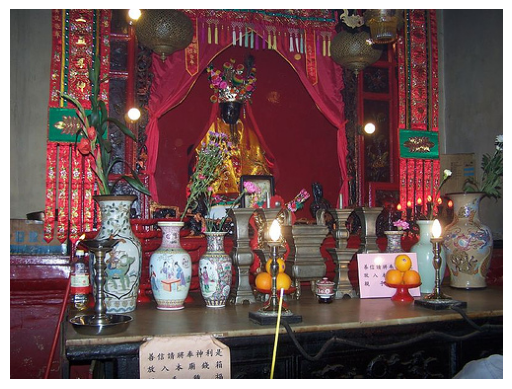

In [89]:
s, imfile = random.choice(r2s['in front of'])
path = "../../data/coco/images/{}/{}".format(imfile.split("_")[1], imfile)
im = Image.open(path)
print(s)
plt.axis("off")
plt.imshow(im)

In [104]:
s = "many vases in front of a shrine"
texts = [s]
input_ids = tokenizer.batch_encode_plus(
        texts,
        return_tensors = "pt",
        padding = True,
        truncation = True
    ).input_ids

encode_subj_obj_with_vl_input = partial(LM.encode_subj_obj_with_vl_input, **config['lm_kwargs'])
encoded_text = encode_subj_obj_with_vl_input([path], texts, [],[])


In [105]:
x = encoded_text.view(-1, model.text_embed_dim) # batch_size*2, dim
x = model.out(model.layers(x))#.transpose(0,1)
print(x.size()) # batch_size, num_classes
tokens = tokenizer.convert_ids_to_tokens(input_ids.tolist()[0])
relations = config['relations'].split()
print(("\n{:16s}" + " {:7s}"*len(relations)).format("token", *relations))
for tok, r in zip(tokens, x):
    probe_scores = [i.item() for i in r]
    print(("{:16s}" +" {:7.4f}"*len(r)).format(tok, *probe_scores))

torch.Size([10, 6])

token            top     bottom  front   behind  inside  outside
[CLS]            -1.4516  0.1780 -2.1547  0.7033 -0.6684  1.9128
many             -1.6589 10.2526 -2.4614 -3.1562 -8.3924 -6.4052
vase              3.5109 -0.1053  2.6353  0.8014 -11.7245 -6.4373
##s              -0.4929  1.4599  6.8318  9.0509 -14.2257 -14.1616
in               -0.1085  6.5324  2.4321 12.2272 -15.3051 -19.0809
front             0.2037 11.1196 -3.1784 11.0323 -5.7811 -29.3250
of                1.7322 10.8474  5.4857  2.4123 -18.8686 -16.3661
a                -1.1115  9.3512 -3.0354  9.5582 -15.6165 -13.9041
shrine            3.5854  2.0752 -9.4782  2.1454  0.2501 -4.5302
[SEP]            -0.9748  1.5146 -4.8163  2.7108  0.8627 -1.7632


#### Does CLIP send information about the correct **relation pair** to nouns?

In [76]:
handle = "0921_104117"
with open(f"ckpts/{handle}/configs.yaml", 'rb') as f: config = yaml.full_load(f.read()) # dict
LM = __import__(config["lm"])
tokenizer = LM.get_tokenizer(**config["lm_kwargs"])

model = PROBE(
    config['hidden_dim_multipliers'], 
    len(config['relations'].split()), 
    config["lm"],
    config["lm_kwargs"]
).to(device)
model.load_state_dict(torch.load(f"ckpts/{handle}/model.pt"))

<All keys matched successfully>

In [77]:
ood_test_data = Texts(
    relations=config['relations'].split(),
    nouns_file=config['ood_nouns_file'],
)
dataloader = DataLoader(ood_test_data, shuffle=True, batch_size=config['batch_size'])


In [78]:
lazy_accs = []
for (texts, labels) in tqdm(dataloader, desc="Testing"):
    output = model(list(texts)) # batch_size*2, num_classes
    gth = torch.cat([labels, 1 - (labels % 2) + 2*(labels // 2)], dim=1).long().view((-1,)).to(device)
    pred = output.argmax(1, keepdim=True)
    print(texts)
    print(pred.squeeze())
    print(gth)
    lazy_accs.append(get_lazy_acc(output, gth).item())
    break
print(len(lazy_accs), np.mean(lazy_accs))
    

Testing:   0%|          | 0/82 [00:00<?, ?it/s]

('a towel is at the bottom of a container', 'a blouse is at the bottom of a hook', 'a calender is outside of a hourglass', 'a saddle is outside of a trumpet', 'a miniature is in front of a container', 'a postcard is on top of a screen', 'a jar is outside of a container', 'a hourglass is on top of a trumpet', 'a dresser is on top of a brownie', 'a hourglass is behind a camera', 'a brownie is inside a face', 'a stone is in front of a camera', 'a jar is outside of a scale', 'a face is at the bottom of a container', 'a plant is behind a face', 'a blouse is behind a face', 'a face is in front of a calender', 'a diary is in front of a screen', 'a dryer is outside of a bathtub', 'a bathtub is at the bottom of a scale', 'a bathtub is outside of a rock', 'a dryer is inside a postcard', 'a camera is inside a cable', 'a camera is outside of a head', 'a cable is outside of a scale', 'a dresser is inside a backpack', 'a bathtub is behind a scale', 'a card is inside a calender', 'a miniature is insi